# CSCE 479/879 Hackathon: Dense Layers, Minibatch Training, and Train/Test Splits

Written by Eleanor Quint

Modified by Mrinal Rawool and Stephen Scott

Topics: 
- Dense layers
- Training by minibatch/gradient step and epoch
- Splitting the dataset into train/validation

This is all setup in a IPython notebook so you can run any code you want to experiment with. Feel free to edit any cell, or add some to run your own code.

In [1]:
%matplotlib inline
# We'll start with our library imports...
from __future__ import print_function

import numpy as np                 # to use numpy arrays
import tensorflow as tf            # to specify and run computation graphs
import tensorflow_datasets as tfds # to load training data
import matplotlib.pyplot as plt    # to visualize data and draw plots
from tqdm import tqdm              # to track progress of loops

DATA_DIR = './tensorflow-datasets/'

#### Preparing the dataset

1. Acquire the dataset
2. Examine elements, splits
3. General rule for model training: train on train_ds, monitor train perf on valid_ds, report final model perf on test_ds

### A First Attempt at Classifying MNIST

MNIST is a dataset of greyscale 28x28 handwritten digits labelled 0 through 9. We'll use it for a 10-class problem to learn the basics of classification.

Let's have a look at the data first. We'll load the data from [Tensorflow Datasets](https://www.tensorflow.org/datasets) and visualize it with matplotlib's `plt.imshow`.

In [2]:
ds = tfds.load('mnist', data_dir=DATA_DIR, shuffle_files=True) # this loads a dict with the datasets

2025-09-10 10:28:32.735815: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :
2025-09-10 10:28:32.735842: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2025-09-10 10:28:32.735855: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (c1217.swan.hcc.unl.edu): /proc/driver/nvidia/version does not exist
2025-09-10 10:28:32.736108: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
print(type(ds))

<class 'dict'>


In [4]:
print(ds.keys())

dict_keys(['train', 'test'])


In [5]:
print(type(ds['train']))

<class 'tensorflow.python.data.ops.dataset_ops._OptionsDataset'>


In [6]:
ds["train"]

<_OptionsDataset shapes: {image: (28, 28, 1), label: ()}, types: {image: tf.uint8, label: tf.int64}>

In [7]:
# We can create an iterator from each dataset
# This one iterates through the train data, shuffling and minibatching by 32
train_ds = ds['train'].shuffle(1024).batch(32) 
# TODO: change 32 to 64 and check the shape of the batch
# shuffle(buffer size)

In [8]:
train_ds

<BatchDataset shapes: {image: (None, 28, 28, 1), label: (None,)}, types: {image: tf.uint8, label: tf.int64}>

In [9]:
train_ds = ds['train'].shuffle(1024).batch(64)
for batch in train_ds:
    print(batch.keys())
    print(batch["image"].shape)
    print(batch["label"].shape)
    break

2025-09-10 10:28:32.886481: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


dict_keys(['image', 'label'])
(64, 28, 28, 1)
(64,)


2025-09-10 10:28:33.125542: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


#### Splitting the dataset into train/validation

Before training, we should split the training dataset into a train set, which will be used for parameter updates, and a validation set, which will not. Then, we can determine which parameters generalise best by calculating the accuracy on the hold-out validation set. The parameters with the highest accuracy on validation will likely generalise the best.

The easiest way to do this is with TensorFlow Datasets is to use their string indexing notation when loading the datasets.

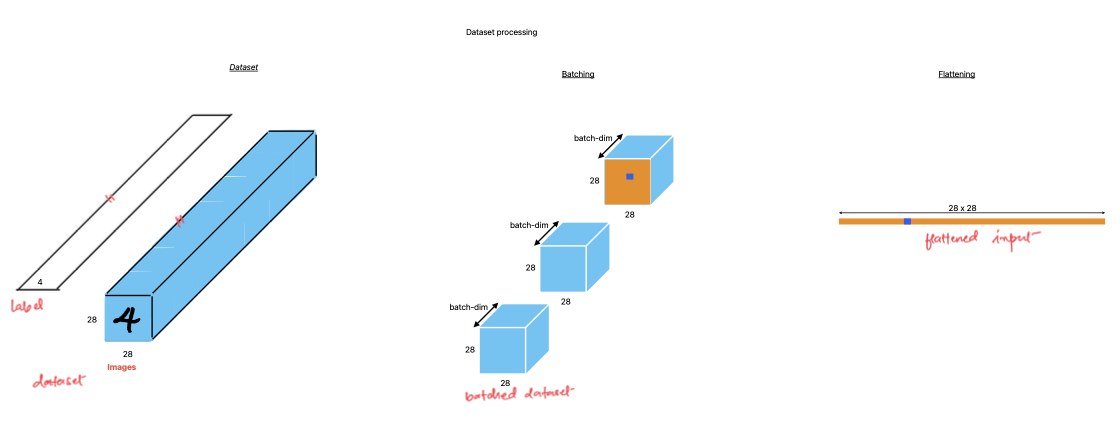

In [10]:
# The first 90% of the training data
# Use this data for the training loop
train = tfds.load('mnist', split='train[:90%]', data_dir=DATA_DIR)

# And the last 10%, we'll hold out as the validation set
# Notice the python-style indexing, but in a string and with percentages
# After the training loop, run another loop over this data without the gradient updates to calculate accuracy
validation = tfds.load('mnist', split='train[-10%:]', data_dir=DATA_DIR)

#### Exploring the dataset

In [11]:
train_ds = ds['train'].shuffle(1024).batch(32)
# Looping through the iterator, each batch is a dict
for batch in train_ds:
    # The first dimension in the shape is the batch dimension
    # The second and third dimensions are height and width
    # Being greyscale means that the image has one channel, the last dimension in the shape
    print("data shape:", batch['image'].shape)
    print("label:", batch['label'])
    break

data shape: (32, 28, 28, 1)
label: tf.Tensor([4 6 2 9 0 1 2 3 9 3 7 4 4 8 6 1 1 2 2 9 3 4 4 5 2 5 9 6 9 4 8 7], shape=(32,), dtype=int64)


2025-09-10 10:28:33.233000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [12]:
# visualize some of the data
idx = np.random.randint(batch['image'].shape[0])
print(idx)

13


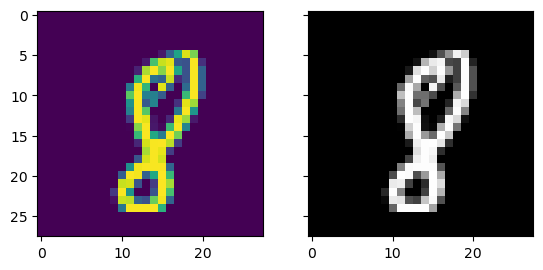

In [13]:
f, axarr = plt.subplots(nrows=1, ncols=2, sharey=True)
axarr[0].imshow(batch['image'][idx]) # It's colored because matplotlib wants to provide more contrast than just greys
axarr[1].imshow(batch['image'][idx], cmap='gray')

In [14]:
batch["label"][idx]

<tf.Tensor: shape=(), dtype=int64, numpy=8>

#### Dense layers

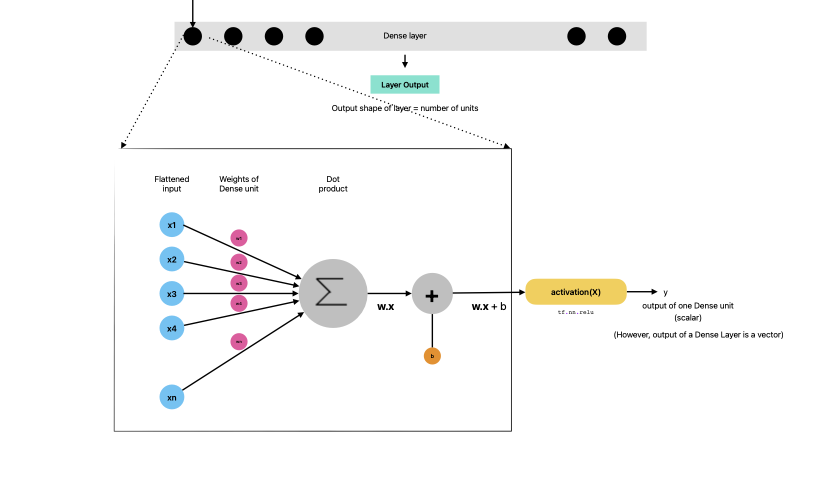

The first step to building a simple neural network is to specify layers. The most basic building block is the dense layer (AKA linear layer or fully connected layer), so we'll declare a function that creates the layer. Each dense layer is composed of two variables, the weight matrix `W` and the bias vector `b` as well as a non-linear activation function `a`, to calculate the function `f(x) = a(Wx + b)`.

Normally we'll use pre-defined layers, but in this notebook we'll do it ourselves first to better understand what's going on under the hood.

In [15]:
class Dense(tf.Module):
    def __init__(self, output_size, activation=tf.nn.relu):
        """
        Args:
            - output_size: (int) number of neurons
            - activation: (function) non-linear function applied to the output
        """
        self.output_size = output_size
        self.activation = activation
        self.is_built = False
        
    def _build(self, x):
        data_size = x.shape[-1]
        self.W = tf.Variable(tf.random.normal([data_size, self.output_size]), name='weights')
        self.b = tf.Variable(tf.random.normal([self.output_size]), name='bias')
        self.is_built = True

    def __call__(self, x):
        if not self.is_built:
            self._build(x)
        return self.activation(tf.matmul(x, self.W) + self.b)

The first dimension of the input is the "batch" dimension, which allows us to run many data through the model simultaneously. The matrix `W` has a row for each input dimension so that each column corresponds to the weights of one linear unit of the layer. After adding the bias vector to the vector resulting from the vector-matrix multiplication, we activate with a non-linearity.

Let's define a simple, two layer network with this function. We activate the first layer with the rectified linear function [`tf.nn.relu`](https://www.tensorflow.org/api_docs/python/tf/nn/relu), but not the second layer so that we can interpret its output as the [logits](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow) of a discrete probability distribution. Note that we're going to flatten the data into a vector (784 = 28 x 28) so that we can use it with a linear layer (we encountered `tf.reshape` in the last hackathon). Loss is calculated with [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy), which implies that we're interpreting the output of the neural network as the paramters of a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution).

Further, we'll train with minibatches of data with the for loop (using tqdm for a progress bar). We run the data forward in each minibatch, calculate the loss using the output logits and correct label, calculate gradients, and finally backprop gradients using the optimizer.apply_gradients() function.

#### Stepping into the code

- We use batch size =1 i.e single image
- pass it through the network (2-layer model) 

In [16]:
sample_img = batch['image'][idx] # examine raw image values. Notce the data type
sample_img[15:20,15:20]

<tf.Tensor: shape=(5, 5, 1), dtype=uint8, numpy=
array([[[106],
        [254],
        [201],
        [  0],
        [  0]],

       [[254],
        [229],
        [ 46],
        [  0],
        [  0]],

       [[246],
        [ 46],
        [  0],
        [  0],
        [  0]],

       [[238],
        [  0],
        [  0],
        [  0],
        [  0]],

       [[253],
        [ 84],
        [  0],
        [  0],
        [  0]]], dtype=uint8)>

In [17]:
sample_lbl = batch['label'][idx]
sample_lbl

<tf.Tensor: shape=(), dtype=int64, numpy=8>

In [18]:
sample_img = tf.cast(sample_img, tf.float32)/255.0 # normalizing image values
sample_img[15:20,15:20]

<tf.Tensor: shape=(5, 5, 1), dtype=float32, numpy=
array([[[0.41568628],
        [0.99607843],
        [0.7882353 ],
        [0.        ],
        [0.        ]],

       [[0.99607843],
        [0.8980392 ],
        [0.18039216],
        [0.        ],
        [0.        ]],

       [[0.9647059 ],
        [0.18039216],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.93333334],
        [0.        ],
        [0.        ],
        [0.        ],
        [0.        ]],

       [[0.99215686],
        [0.32941177],
        [0.        ],
        [0.        ],
        [0.        ]]], dtype=float32)>

In [19]:
first_layer = Dense(200) # local Dense. Standard TF Dense class is tf.keras.layers.Dense()
second_layer = Dense(10)

In [20]:
print("Before: ", sample_img.shape)
sample_img = tf.reshape(sample_img, [-1, 784])
print("After: ", sample_img.shape)

Before:  (28, 28, 1)
After:  (1, 784)


In [21]:
fl_op = first_layer(sample_img) # batch size = 1
fl_op.shape

TensorShape([1, 200])

In [22]:
fl_op[0, :10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([ 1.0967731 , 15.5825815 ,  6.4818583 ,  0.        ,  3.6235955 ,
       11.548216  ,  0.        ,  0.07339191,  2.8756738 ,  0.        ],
      dtype=float32)>

In [23]:
sl_op = second_layer(fl_op)
sl_op.shape

TensorShape([1, 10])

In [24]:
sl_op 
# Logits are the unnormalized probabilities of the item belonging to a certain class. 

<tf.Tensor: shape=(1, 10), dtype=float32, numpy=
array([[ 0.      ,  0.      , 22.46242 ,  0.      ,  0.      , 43.865715,
        68.36589 ,  0.      ,  0.      ,  0.      ]], dtype=float32)>

In [25]:
probabilities = tf.nn.softmax(sl_op)
print(probabilities)
print("")
print("Sum of label probabilities is ", tf.reduce_sum(probabilities).numpy())

tf.Tensor(
[[2.0373751e-30 2.0373751e-30 1.1597784e-20 2.0373751e-30 2.0373751e-30
  2.2893331e-11 1.0000000e+00 2.0373751e-30 2.0373751e-30 2.0373751e-30]], shape=(1, 10), dtype=float32)

Sum of label probabilities is  1.0


In [26]:
sample_pred_logits = tf.argmax(sl_op, axis=1)
sample_pred_logits[0].numpy()

6

In [27]:
sample_pred_proba = tf.argmax(probabilities, axis=1)
sample_pred_proba[0].numpy()

6

In [28]:
sample_lbl.numpy()

8

In [29]:
# accuracy calc
print("Is sample == label? ", tf.equal(sample_pred_logits[0], sample_lbl))
print("\nConverting Bool to Float to allow summation: ", tf.cast(tf.equal(sample_pred_logits[0], sample_lbl), tf.float32))
# accuracy for batch size 1/ one image
print("\nAccuracy over batch of 1 image: ", tf.reduce_mean(tf.cast(tf.equal(sample_pred_logits[0], sample_lbl), tf.float32)).numpy())

Is sample == label?  tf.Tensor(False, shape=(), dtype=bool)

Converting Bool to Float to allow summation:  tf.Tensor(0.0, shape=(), dtype=float32)

Accuracy over batch of 1 image:  0.0


In [30]:
sl_op.shape

TensorShape([1, 10])

In [31]:
# Loss calc

# Measures the probability error in discrete classification tasks in which the 
# classes are mutually exclusive (each entry is in exactly one class).

# This op expects unscaled logits, since it performs a softmax on logits internally for efficiency. 
# Do not call this op with the output of softmax, as it will produce incorrect results.

sample_loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=sl_op[0], labels=sample_lbl)
sample_loss.numpy() # -log(p)

68.36589

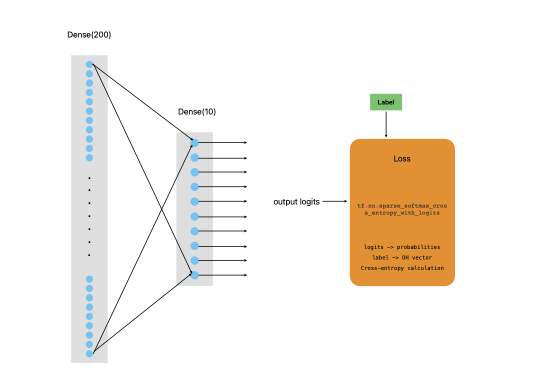

In [32]:
first_layer = Dense(200)
second_layer = Dense(10)

loss_values = []
accuracy_values = []

for batch in tqdm(train_ds):
    # run network
    x = tf.reshape(tf.cast(batch['image'], tf.float32)/255., [-1, 784]) # -1 means everyting not otherwise accounted for
    print("After reshaping input batch", x.shape)
    labels = batch['label']
    print("Label shape: ", labels.shape)
    x = first_layer(x)
    print("FL output shape: ", x.shape)
    logits = second_layer(x)
    print("SL output shape: ", logits.shape)
    
    # calculate loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    print("Loss shape: ", loss.shape)
    loss_values.append(loss)
    print("Loss values shape: ", len(loss_values))
    
    # calculate accuracy
    predictions = tf.argmax(logits, axis=1)
    print("predictions: ", predictions.shape)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
    print("accuracy: ", accuracy.shape)
    accuracy_values.append(accuracy)
    print("Accuracy values shape: ", len(accuracy_values))
    
    print("=================")
    print(labels)
    print(predictions)
    print("Batch accuracy: ", np.mean(accuracy_values)) # 0.125*32 = 4
    correct_preds = tf.math.reduce_sum(tf.cast(tf.equal(labels, predictions), tf.float32)).numpy()
    print("\nNum. correct preds= {}, After dividing by batch size 32: {} ".format(correct_preds, correct_preds/32.0 ))
    
    break

  0%|          | 0/1875 [00:00<?, ?it/s]

After reshaping input batch (32, 784)
Label shape:  (32,)


2025-09-10 10:28:34.296939: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
  0%|          | 0/1875 [00:00<?, ?it/s]

FL output shape:  (32, 200)
SL output shape:  (32, 10)
Loss shape:  (32,)
Loss values shape:  1
predictions:  (32,)
accuracy:  ()
Accuracy values shape:  1
tf.Tensor([0 4 8 8 8 7 4 1 7 1 4 5 8 5 1 0 2 2 9 9 9 1 0 7 0 8 7 9 1 7 9 3], shape=(32,), dtype=int64)
tf.Tensor([1 9 3 3 3 6 1 7 9 7 7 3 3 1 7 1 3 3 3 7 9 8 1 3 7 7 6 7 1 7 6 1], shape=(32,), dtype=int64)
Batch accuracy:  0.09375

Num. correct preds= 3.0, After dividing by batch size 32: 0.09375 


#### Orig code: Running batch through a small two layer model

- Only forward pass
- Only one batch = 32 images

100%|██████████| 1875/1875 [00:03<00:00, 479.28it/s]


Number of batches parsed:  1875
Accuracy: 0.11355
Min. loss value:  0.0 Max loss value:  94269.15


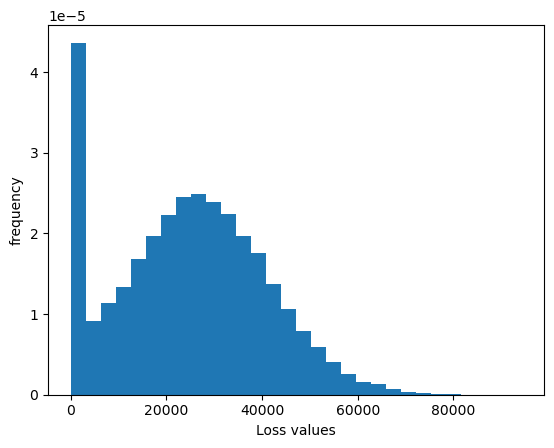

In [33]:
first_layer = Dense(200)
second_layer = Dense(10)

loss_values = []
accuracy_values = []
# Loop through one epoch of data
for batch in tqdm(train_ds):
    # run network
    x = tf.reshape(tf.cast(batch['image'], tf.float32), [-1, 784]) # -1 means everyting not otherwise accounted for
    labels = batch['label']
    x = first_layer(x)
    logits = second_layer(x)
    
    # calculate loss
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)
    loss_values.append(loss)
    
    # calculate accuracy
    predictions = tf.argmax(logits, axis=1)
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
    accuracy_values.append(accuracy)
    
    
print("Number of batches parsed: ", len(loss_values))

# print accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
print("Min. loss value: ", np.min(loss_values), "Max loss value: ", np.max(loss_values))
plt.hist(loss_values, density=True, bins=30)
plt.xlabel("Loss values")
plt.ylabel("frequency")
plt.show()

#### Training by minibatch/gradient step and epoch

Now let's re-declare the network with pre-defined layers using [`tf.keras.layers.Dense`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), group the layers using [`tf.keras.Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential), and training the parameters with the [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) optimizer.

Note how [`tf.GradientTape`](https://www.tensorflow.org/guide/autodiff) is used. We run all the computations which we want to backpropagate gradients through in the scope of the tape and then, after the loss is calculated, we can call `tape.gradient` to calculate the gradient of the output with respect to the model variables.

100%|██████████| 1875/1875 [00:04<00:00, 376.16it/s]


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (32, 200)                 157000    
_________________________________________________________________
dense_3 (Dense)              (32, 10)                  2010      
Total params: 159,010
Trainable params: 159,010
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 0.9299833
Min. loss value:  0.0 Max loss value:  15.401514


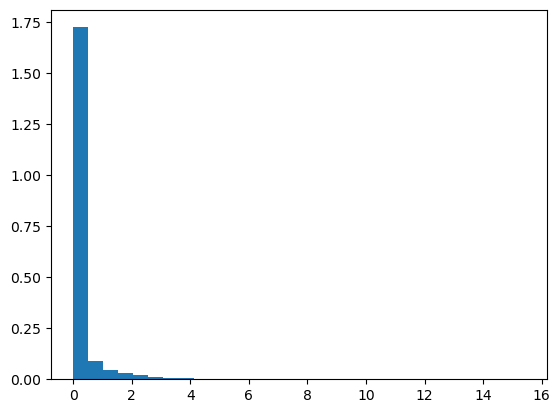

In [35]:
# using Sequential groups all the layers to run at once
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(200, tf.nn.relu))
model.add(tf.keras.layers.Dense(10))
optimizer = tf.keras.optimizers.Adam()

loss_values = []
accuracy_values = []
batch_loss = []
i=1
# Loop through one epoch of data
for epoch in range(1):
    for batch in tqdm(train_ds):
        with tf.GradientTape() as tape:
            # run network
            x = tf.reshape(tf.cast(batch['image'], tf.float32)/255.0, [-1, 784])
            labels = batch['label']
            logits = model(x)
            # n_batches+=1

            # calculate loss
            loss = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels)    
            scalar_loss = tf.reduce_mean(loss)
        loss_values.append(loss.numpy())
        batch_loss.append(scalar_loss.numpy())
    
        # gradient update
        # grads = tape.gradient(loss, model.trainable_variables)
        grads = tape.gradient(scalar_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
        # calculate accuracy
        predictions = tf.argmax(logits, axis=1)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels), tf.float32))
        accuracy_values.append(accuracy)

print(model.summary())
    
# accuracy
print("Accuracy:", np.mean(accuracy_values))
# plot per-datum loss
loss_values = np.concatenate(loss_values)
print("Min. loss value: ", np.min(loss_values), "Max loss value: ", np.max(loss_values))
plt.hist(loss_values, density=True, bins=30)
plt.show()

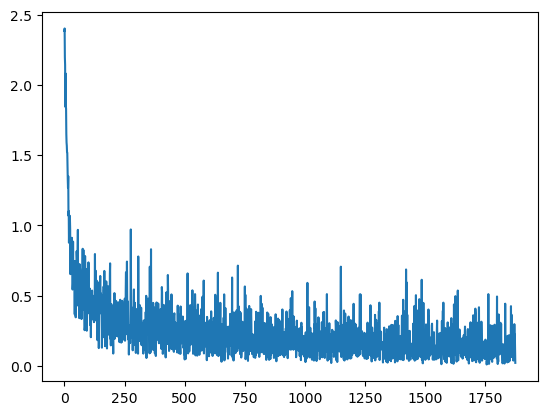

In [36]:
plt.plot(batch_loss)
plt.show()

### Homework

Your homework is 
- to specify a network with `tf.keras.layers`, 
- train it on the MNIST dataset (as above, but with train/validation split), 
- use val split to avoid overfitting/ monitor training perf
- use test split to report final model perf on unseen data
- and try out 2 or 3 variations of different architectures. 
    - I.e., change the number of neurons or layers, 
    - change the activation function (you can find more in the documentation at [`tf.nn` (https://www.tensorflow.org/api_docs/python/tf/nn)), or even change the optimizer ([`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)). 
    
Write up a paragraph or two with your observations. E.g., 
- how did it affect the final accuracy on the validation data? 
- How did it affect the rate at which the model improved? Remember to add early stopping and increase the number of training epochs. 

**Submit a `.pdf` with the writeup and `.py` with the code.**

I'm expecting this to take about an hour (or less if you're experienced). Feel free to use any code from this or previous hackathons. If you don't understand how to do any part of this or if it's taking you longer than that, please let me know in office hours or by email (both can be found on the syllabus). I'm also happy to discuss if you just want to ask more questions about anything in this notebook!

### Coda

In [ ]:
from IPython.display import HTML
# From Colah's Blog, linearly separating spirals with linear transforms and non-linearities
# How does a neural network separate entangled data?
print("We want the blue and red lines to be linearly separable, so how does a neural network manage to do this?\
 Let's visualize the linear transformations and non-linearities.")
HTML('<img src="http://colah.github.io/posts/2014-03-NN-Manifolds-Topology/img/spiral.1-2.2-2-2-2-2-2.gif">')